#### Author : Sam Raj Anand 
#### Date     : March 2021
#### Project : Practicum Project with InpharmD

In [1]:
import sqlite3
from requests.exceptions import Timeout, ConnectionError
import time
from time import sleep
import pandas as pd
import pyodbc
import spacy
import re
import numpy as np
import nltk 
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os


C:\Users\samra\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data Loading

In [2]:
# Step 1 : Data Loading 
    
# Executing method to read json file into pandas dataframe
raw_data_0 = pd.read_json('inquiry_0.json')
raw_data_1 = pd.read_json('inquiry_1.json')
raw_data_2 = pd.read_json('inquiry_2.json')
raw_data_3 = pd.read_json('inquiry_3.json')
raw_data_4 = pd.read_json('inquiry_4.json')
raw_data_5 = pd.read_json('inquiry_5.json')
    

In [3]:
# Consolidate the Dataframes 

raw_data = raw_data_0.append(raw_data_1)
raw_data = raw_data.append(raw_data_2)
raw_data = raw_data.append(raw_data_3)
raw_data = raw_data.append(raw_data_4)
raw_data = raw_data.append(raw_data_5)


### Data Exploration

In [4]:
# Step 1A : Explore the dataset 

raw_data.dtypes

id                                  int64
submitter_id                        int64
assignee_id                       float64
created_at                 datetime64[ns]
turnaround_time                    object
status                             object
question                           object
title                              object
researchable_question              object
read_at                    datetime64[ns]
intervention_response                bool
custom_response_text               object
search_strategy                    object
background                         object
prescribing_information            object
is_unread                            bool
view_everyone                        bool
summary_tables                     object
hidden_sections                    object
level_of_evidence                 float64
submitter_team                     object
dic_center_details                 object
project_types                      object
documents                         

In [5]:
# Step 1B : Futher Exploring the dataset
display(raw_data.head(5))

print('Total Rows in the dataset :' , len(raw_data))

,id,submitter_id,assignee_id,created_at,turnaround_time,status,question,title,researchable_question,read_at,...,summary_tables,hidden_sections,level_of_evidence,submitter_team,dic_center_details,project_types,documents,is_favourite,shareable_url,approved_at
0,52,2,NaN,2014-02-13 15:32:03,a_week,complete,Test,None,None,NaT,...,[],None,NaN,{'name': 'WellStar Atlanta Medical Center (Mai...,None,None,NaN,NaN,None,NaT
1,58,2,31.0,2014-02-22 22:26:59,asap,complete,Test \n,None,None,NaT,...,[],None,NaN,{'name': 'WellStar Atlanta Medical Center (Mai...,None,None,NaN,NaN,None,NaT
2,62,2,41.0,2014-03-03 15:09:29,asap,complete,Test\n,None,None,NaT,...,[],None,NaN,{'name': 'WellStar Atlanta Medical Center (Mai...,None,None,NaN,NaN,None,NaT
3,64,2,NaN,2014-03-04 21:44:24,asap,complete,Test 1\n,None,None,NaT,...,[],None,NaN,{'name': 'WellStar Atlanta Medical Center (Mai...,None,None,NaN,NaN,None,NaT
4,65,2,42.0,2014-03-04 21:44:44,asap,complete,Test 2\n,None,None,NaT,...,[],None,NaN,{'name': 'WellStar Atlanta Medical Center (Mai...,None,None,NaN,NaN,None,NaT


Total Rows in the dataset : 5223


### Data Munging

In [6]:
# Step 2: Data Filtering

# Remove the rows having no title
raw_data = raw_data[raw_data['title'].notna()]
print('Total Rows in the dataset :' , len(raw_data))

#raw_data.question[5:10]

display(raw_data.iloc[203]['question'])

Total Rows in the dataset : 4167


'Is one muscle relaxer (cyclobenzaprine/tizanadine) more effective than another? Is one favored as first line therapy?'

In [7]:
# Step 2A: Data Splitting into train and test dataset 

train_data = raw_data.sample(frac=1.0, random_state=0)
test_data  = raw_data.drop(train_data.index)

print('Total Rows in the train dataset :' , len(train_data))
print('Total Rows in the test dataset :' , len(test_data))


display(train_data[['id', 'question', 'title', 'custom_response_text', 'view_everyone', 'shareable_url' ]].head(5))
display(test_data[['id', 'question', 'title', 'custom_response_text', 'view_everyone', 'shareable_url' ]].head(5))

train_data = train_data.reset_index(drop=True)


Total Rows in the train dataset : 4167
Total Rows in the test dataset : 0


,id,question,title,custom_response_text,view_everyone,shareable_url
866,5155,What are considered suitable alternatives for ...,What are considered suitable alternatives for ...,There is no literature comparing alternatives ...,True,https://inpharmd.com/what-are-considered-suita...
296,1906,is there an interaction between triptans and a...,Are there drug interactions between triptans a...,"Based on evidence, there are no known drug int...",False,None
960,6390,I review the EENT formulary products for P&T a...,EENT formulary review 2021,Attached is the updated formulary review for E...,False,None
343,1960,Patient Info\r\n\r\n63 year old Male\r\nCurre...,What does the literature say about switching f...,There are no guideline recommendations on dosa...,False,None
203,1794,Clinical criteria for medical induction,What are the clinical indications for labor in...,Clinical guidelines have outlined indications ...,False,None


,id,question,title,custom_response_text,view_everyone,shareable_url


### Data Wrangling

In [8]:
# Step 2B: Creating the Document attribute  (Title + Question + Response)

train_data['document'] = train_data['title'].astype(str) + train_data['question'].astype(str) + train_data['custom_response_text'].astype(str) + train_data['background'].astype(str)

train_data['document'] = train_data['document'].astype(str)

#display(train_data[['title', 'question', 'custom_response_text', 'document']].head(1))





In [9]:
# Step 2C: Data Cleaning

import warnings
import string 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Cleaing using the Regular expression library
#  Remove URLs
train_data['document'] = train_data['document'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# Remove punctuation
train_data['document'] = train_data['document'].map(lambda x: re.sub('[,\.!?@]', ' ', x))
# Remove punctuation
train_data['document'] = train_data['document'].map(lambda x: re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'']', ' ', x))
# Convert the titles to lowercase
train_data['document'] = train_data['document'].map(lambda x: x.lower())
# Removing the word 'amp' 
train_data['document'] = train_data['document'].map(lambda x: re.sub('amp', ' ', x))
#remove times pm
train_data['document'] = train_data['document'].map(lambda x: re.sub('\d+pm', ' ', x))

# Remove words with charceters less than 2 charceters 
train_data['document'] = train_data['document'].map(lambda x: re.sub(r'\b\w{1,2}\b', '',x))
# Remove New line charecters
train_data['document'] = train_data['document'].map(lambda x: x.rstrip("\n"))
# Remove punctuation
train_data['document'] = train_data['document'].map(lambda x: x.replace("\\", " "))
# Remove words with only numbers 
train_data['document'] = train_data['document'].map(lambda x: re.sub(r'\b[0-9]+\b\s*', '', x))
# Remove all alpha-numeric charecters in string 
train_data['document'] = train_data['document'].map(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))


<>:9: DeprecationWarning: invalid escape sequence \/
<>:11: DeprecationWarning: invalid escape sequence \.
<>:13: DeprecationWarning: invalid escape sequence \]
<>:19: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \/
<>:11: DeprecationWarning: invalid escape sequence \.
<>:13: DeprecationWarning: invalid escape sequence \]
<>:19: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \/
<>:11: DeprecationWarning: invalid escape sequence \.
<>:13: DeprecationWarning: invalid escape sequence \]
<>:19: DeprecationWarning: invalid escape sequence \d
<ipython-input-9-a128ef382be6>:9: DeprecationWarning: invalid escape sequence \/
  train_data['document'] = train_data['document'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
<ipython-input-9-a128ef382be6>:11: DeprecationWarning: invalid escape sequence \.
  train_data['document'] = train_data['document'].map(lambda x: re.sub('[,\.!?@]', ' ', x

In [10]:
# Step 2D: Replacing text  

train_data['document'] = train_data['document'].map(lambda x: re.sub("it's",'', x))
train_data['document'] = train_data['document'].map(lambda x: re.sub("n't",'', x))
train_data['document'] = train_data['document'].map(lambda x: re.sub("'",'', x))
train_data['document'] = train_data['document'].map(lambda x: re.sub("-",'', x))
train_data['document'] = train_data['document'].map(lambda x: re.sub(",",'', x))

In [11]:
# Step 2E: Removing Stopwords 

STOPWORDS = set(stopwords.words('english','spanish'))
def remove(text,wordset=STOPWORDS):
    splits = text.split()
    result=[]
    for split in splits:
        if split not in wordset:
            result.append(split.strip())
    return (" ".join(result))        

train_data['document'] = train_data['document'].apply(lambda x: remove(x))


In [12]:
# Step 2F: Eliminate additional words from Corpus

eliminate_words = {'today', 'year', 'patient', 'time', 'great', 'day', 'morning', 'evening', 'community', 'important',
                   'many', 'family', 'sure', 'visit', 'https', 'new', 'work', 'proud', 'thank', 'good', 'way', 'help',
                   'need', 'member', 'week', 'nation', 'support', 'last', 'effort', 'yesterday', 'news', 'watch', 'state',
                   'safe', 'happy', 'birthday', 'colleague', 'tonight', 'part', 'much', 'now', 'country', 'leader', 'program',
                   'congratulation', 'conversation', 'fact', 'government', 'house', 'right', 'tomorrow', 'question', 'long',
                   'public', 'big', 'million', 'benefit', 'information', 'report' , 'friend', 'life', 'bad' , 'word', 'true',
                   'woman', 'man', 'local', 'action', 'resource', 'high','school', 'opportunity', 'town', 'event', 'meeting',
                   'tune', 'pm', 'student', 'live', 'discussion', 'discuss', 'child', 'world', 'policy', 'condition', 'hand',  
                   'office', 'place', 'resident', 'site' , 'concern', 'city', 'free', 'congressional', 'WORKER', 'history',
                   'wonderful', 'team', 'update', 'facebook', 'minute', 'op', 'water', 'food', 'hour', 'pm', 
                   'thing', 'art', 'folk', 'annual', 'prayer', 'thought', 'heart', 'statement', 'story', 'special', 'pre',
                   'honor', 'young', 'neighbor', 'night', 'district', 'late', 'moment', 'case', 'census', 'person', 'voice', 
                   'wrong',  'share', 'victory', 'grateful', 'century', 'kid', 'difficult', 'afternoon', 'love', 'youth', 
                   'fellow', 'mother',  'comment', 'official','p','m','p m', 'literature', 'hour', 'available', 'drug', 
                   'et', 'al', 'r', 'n', '1', 'send', 'ask', 'use', 'used', 'one'}




train_data['document'] = train_data['document'].apply(lambda x: remove(x, wordset=eliminate_words))

In [13]:
# Step 3: Retain only the Nouns and Adjectives in every document using Lemmatization  

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
#    """https://spacy.io/api/annotation"""
#    doc = nlp(texts) 
#    texts_out = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#    return texts_out     

# Do lemmatization keeping only noun, adj parts of speech (POS)
#train_data['document'] = train_data['document'].apply(lambda x: lemmatization(x, allowed_postags=['NOUN', 'ADJ']))

# Step 3: Defining the similarity between words 

def replace_synonyms(text):
    splits = text.split()
    result=[]
    for split in splits:
        if split in synonyms:
            result.append(synonyms[split])
        else:
            result.append(split)
    return (" ".join(result))        

#replace synonyms
synonyms = {'covid19':'covid','covid-19':'covid', 'vaccine':'vaccines' , 'vaccine':'vaccination' }

train_data['document'] = train_data['document'].apply(lambda x: replace_synonyms(x))


In [14]:
#train_data['document'][0]

### Visualizing Word Cloud

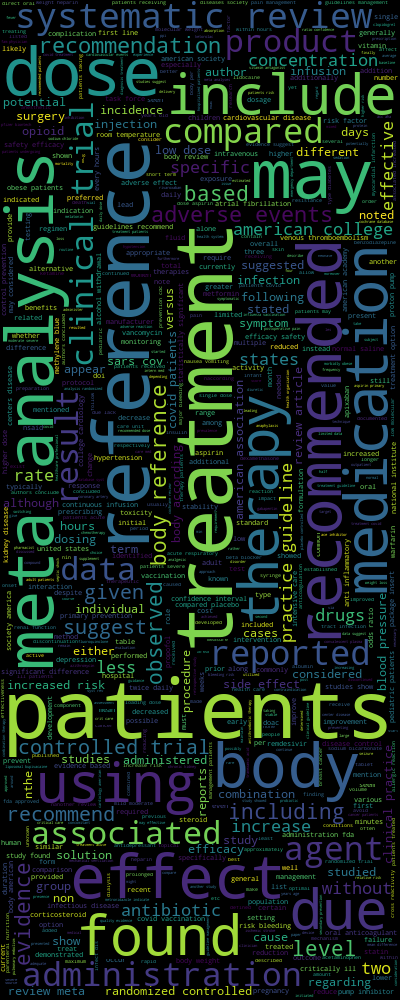

In [15]:
# Step 4: Exploratory Analysis using Wordcloud creation 

# Import the wordcloud library
# Join the different processed questions together.
long_string = ','.join(list(train_data['document'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=2000, contour_width=1000, height=1000, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [16]:
# Step 5: Further Exploration of words in Documents 

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

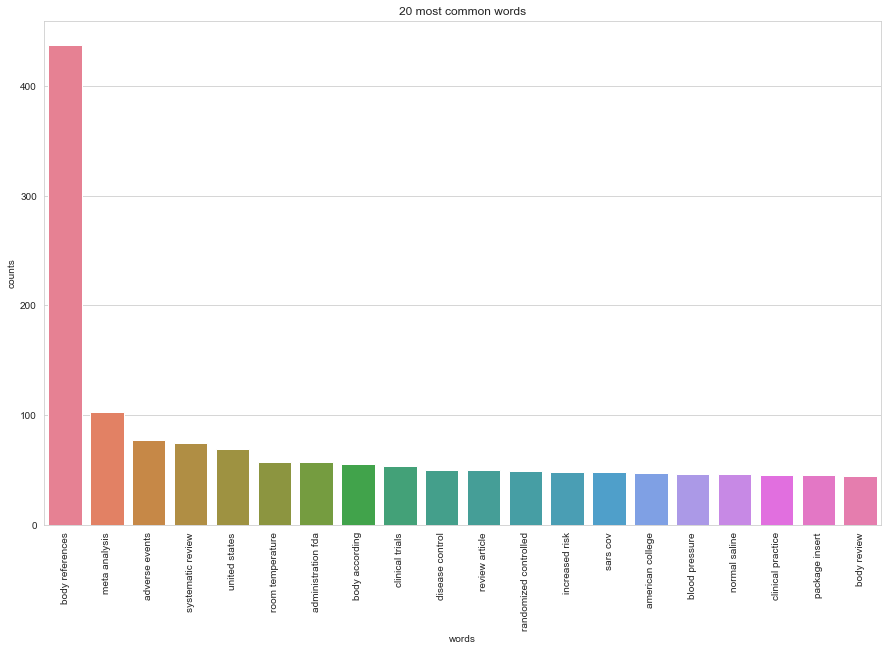

In [17]:
# Step 5A: Visualizing the Top 20 pairs of words 

# 20_most_common_words in documents
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(train_data["document"])   

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer= TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english', max_features= 1000)
# Fit and transform the processed documents 
count_data= count_vectorizer.fit_transform(train_data['document'])
# Visualise the 20 most common words
plot_20_most_common_words(count_data, count_vectorizer)

### NLP: Vectorizing the Corpus

In [18]:
# Step 6: Data Preparation before training Model 
#         Creating the Document Term Sparse Matrix 

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')

# Calculate DocTerm Matrices
count_vectorizer.fit(train_data['document'])

TfidfVectorizer(stop_words='english', strip_accents='ascii',
                token_pattern='\\w{1,}')

In [19]:
# Transform the train dataset using the tfidf transformer 

train_data_tfidf = count_vectorizer.transform(train_data['document'])

In [20]:
# Step 6A : Viewing the TFIDF for words in 1st document 
print(train_data_tfidf[203,:])
print(train_data_tfidf.shape)

  (0, 40689)	0.025494096071137232
  (0, 40418)	0.02424044456916579
  (0, 40224)	0.07789493326582722
  (0, 39679)	0.02445168011414241
  (0, 39425)	0.02408235454816416
  (0, 39414)	0.021304060171663787
  (0, 39182)	0.018180283234538692
  (0, 39067)	0.020011826449858706
  (0, 38394)	0.023729544194127324
  (0, 38391)	0.013524177820760801
  (0, 38346)	0.009172838049156033
  (0, 38341)	0.016376941985109736
  (0, 38321)	0.025676888503291872
  (0, 38262)	0.03182014585108756
  (0, 37997)	0.025676888503291872
  (0, 37977)	0.028198443134888247
  (0, 37942)	0.023657836212943595
  (0, 37457)	0.01591326842547208
  (0, 37431)	0.09651692465161286
  (0, 37350)	0.03255267254921207
  (0, 37305)	0.02108637246370672
  (0, 37288)	0.030006589221669138
  (0, 37261)	0.030554465407054206
  (0, 36895)	0.04013747503392259
  (0, 36751)	0.032519846668353655
  :	:
  (0, 3383)	0.029893368640763193
  (0, 3221)	0.03339018921534068
  (0, 3192)	0.01879562662701864
  (0, 2998)	0.013633760323899598
  (0, 2745)	0.0162599233

### Training the LDA model 

In [20]:
from gensim import corpora
#Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Create Dictionary
text=[[text for text in doc.split()] for doc in train_data['document']]
dictionary1 = corpora.Dictionary(text)
corpus=[dictionary1.doc2bow(text) for text in text]

#Build manual tokenized topics
def TokenTopics(DocTerm, TopicAffinity,NumTerms=10):
    result=[]
    for i,topic in enumerate(TopicAffinity):
        result.append([DocTerm.get_feature_names()[i] for i in topic.argsort()[-NumTerms:]]) 
    return result

def CalculateCoherence(corpus1,dictionary1,text1,tt,coherence='c_v'):
    cm=0
    if coherence[0]=='u':
        cm = CoherenceModel(topics=tt, corpus=corpus, dictionary=dictionary1, coherence=coherence,processes=-1)    
    else: 
        cm = CoherenceModel(topics=tt, texts=text, dictionary=dictionary1, coherence=coherence,processes=-1)
    return cm.get_coherence()

In [ ]:
#for key, value in dictionary1.items():
#    if value == 'study':
#        print(key)


In [ ]:
#Try different topic sizes, parameters
from gensim.models.coherencemodel import CoherenceModel
coherence = dict()

for a in range(5,100):
    lda= LDA(n_components=a, n_jobs=-1, doc_topic_prior=0.01, topic_word_prior=0.01, learning_method='batch', learning_decay=0.5, learning_offset=10.0, max_iter=20, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, verbose=0, random_state=42)
    lda_result=lda.fit_transform(train_data_tfidf)
    tt = TokenTopics(count_vectorizer,lda.components_)
    
    label='p'+str(a)
    coherence[label]=CalculateCoherence(corpus,dictionary1,text,tt,'c_v')

coherence_score = list(coherence.values())    
coherence_score    

#### Visualizing the  Coherence Score 

In [ ]:
# Show graph

import matplotlib.pyplot as plt
x = range(50,80)
plt.plot(x, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
#Create the LDA Model with Optimal paramters obtained from above step

number_topics = 100

lda = LDA(n_components=number_topics, n_jobs=-1, doc_topic_prior=0.01, topic_word_prior=0.01, learning_method='batch', learning_decay=0.5, learning_offset=10.0, max_iter=25, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, verbose=0, random_state=42)
lda_result=lda.fit_transform(train_data_tfidf)

In [72]:
# printing the topics and the Top 10 words in that topic 
terms = count_vectorizer.get_feature_names()
topic= dict()

for i, comp in enumerate(lda.components_):
    print_topic = [] 
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    label = "topic_" + str(i)
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print_topic.append(t[0])
    print(print_topic)
    topic[label] = print_topic[0] + '-' + print_topic[1] + '-' + print_topic[2]

Topic 0: 
['bupivacaine', 'exparel', 'liposomal', 'ropivacaine', 'falls', 'tenofovir', 'ascvd', 'dolutegravir', 'guaifenesin', 'restless']
Topic 1: 
['n95', 'masks', 'mask', 'niosh', 'trehalose', 'psoriasis', 'crisis', 'intraventricular', 'norvasc', 'guaifenesin']
Topic 2: 
['pancreatic', 'prevnar', 'humulin', 'pcv13', 'fistula', 'pneumococcal', 'octreotide', 'nph', 'humalog', 'iiv']
Topic 3: 
['warming', '2020emerging', 'dyloject', 'grapefruit', 'appendage', 'raynaud', 'gemcitabine', 'intraoperative', 'cling', 'apap']
Topic 4: 
['ibuprofen', 'minister', 'ace2', 'france', 'sickle', 'registered', 'gemcitabine', 'entresto', 'providers', 'prochlorperazine']
Topic 5: 
['desensitization', 'atropine', 'anthrax', 'sumatriptan', 'cyclopentolate', 'myopia', 'anticonvulsant', 'ciwa', 'primidone', '27test']
Topic 6: 
['milk', 'breastfeeding', 'pcos', 'biktarvy', 'juice', 'osmolality', 'infant', 'mothers', 'mosm', 'betamethasone']
Topic 7: 
['buprenorphine', 'august', 'rhinosinusitis', 'july', 'vi

In [73]:
# Print the Document and the topic it is highly correlated with 
columns = []

for i in range(number_topics): 
    columns.append("topic_" + str(i))

pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(lda_result, columns=columns)
topic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)
topic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df["question"] = train_data["question"].values
topic_encoded_df["custom_response_text"] = train_data["custom_response_text"].values
topic_encoded_df["background"] = train_data["background"].values
topic_encoded_df["view_everyone"] = train_data["view_everyone"].values
topic_encoded_df["shareable_url"] =  train_data["shareable_url"].values
topic_encoded_df["id"] = train_data['id'].values
display(topic_encoded_df[["id", "custom_response_text",  "probable_Topic", "Topic_Probability"]])


,id,custom_response_text,probable_Topic,Topic_Probability
0,5155,There is no literature comparing alternatives ...,topic_5,0.5077600687462928
1,1906,"Based on evidence, there are no known drug int...",topic_54,0.5642662808833916
2,6390,Attached is the updated formulary review for E...,topic_54,0.4834586988026968
3,1960,There are no guideline recommendations on dosa...,topic_54,0.4527949125770404
4,1794,Clinical guidelines have outlined indications ...,topic_54,0.4350739525756113
...,...,...,...,...
4162,2881,"Low, over-the-counter doses of ibuprofen (200 ...",topic_54,0.5931493143268119
4163,5668,,topic_58,0.7367193262554389
4164,3744,Desmopressin monitoring includes serum electro...,topic_54,0.5055681576401981
4165,4911,There are currently three clinical trials test...,topic_54,0.6176954360149230


#### Visualizing the Topics 

In [74]:
# Visualizing the Topic Distribution in a PCA setting 

import time
from time import sleep

time
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
if True:
        LDAvis_prepared = sklearn_lda.prepare(lda, train_data_tfidf, count_vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)


# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

import webbrowser
#print(os.path.join('./ldavis_prepared_'+ str(number_topics) +'.html'))
webbrowser.open('http://localhost:8888/view/Desktop/Georgia_tech_MA_AI/Spring%202021/ldavis_prepared_' + str(number_topics) +'.html')


True

### Training the Truncated SVD Model 

In [21]:
from sklearn.decomposition import TruncatedSVD

# Reducing to just 300 dimensions from original 41,520 dimensions 

print ("Orig_features.shape = {0}".format(train_data_tfidf.shape))
result_svd = TruncatedSVD(n_components=300)
result_features = result_svd.fit_transform(train_data_tfidf)

print ("result_features.shape = {0}".format(result_features.shape))


Orig_features.shape = (4167, 41519)
result_features.shape = (4167, 300)


#### Visualizing the features in Reduced Dimension

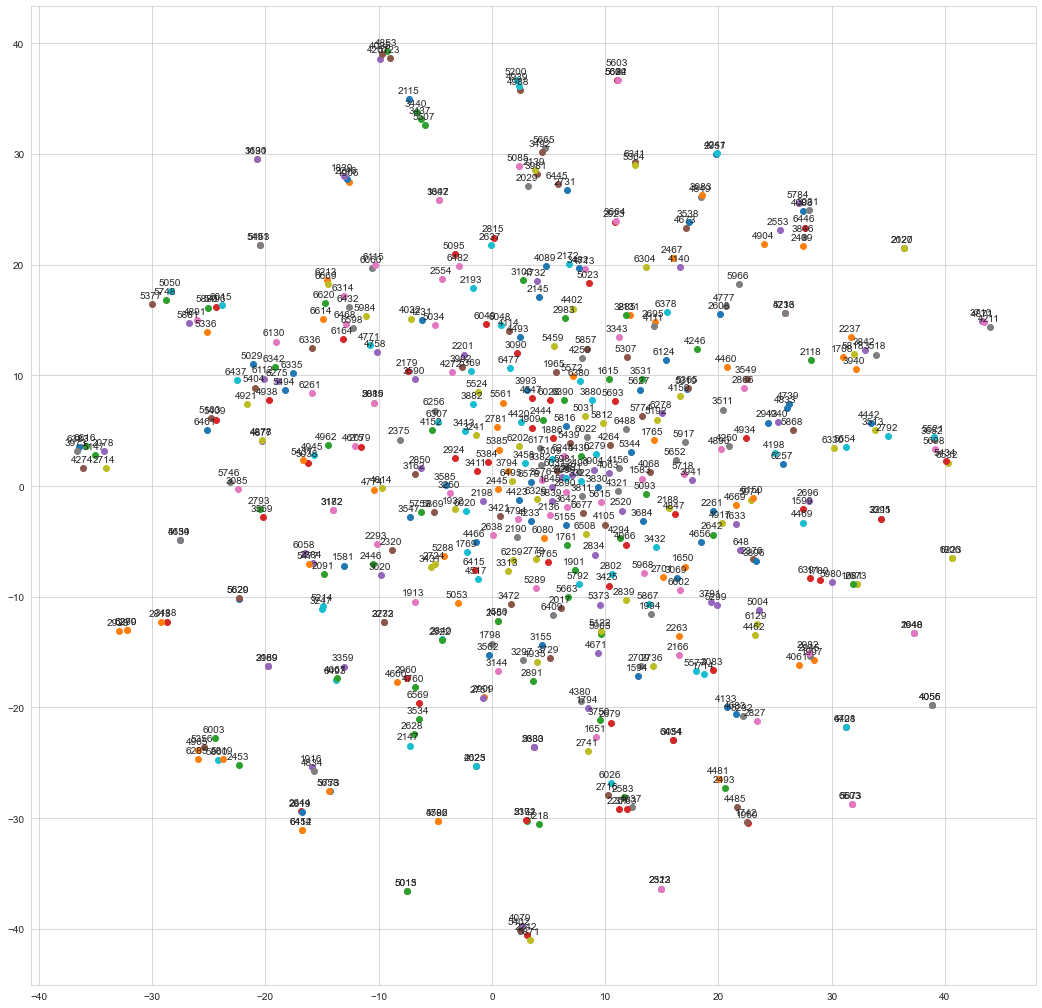

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

tsne = TSNE(perplexity=15, n_components=2, init="pca", n_iter=5000)
plot_only = 500
coords = tsne.fit_transform(result_features[:plot_only, :])

plt.figure(figsize=(18, 18))
labels = [train_data.iloc[i].id for i in range(plot_only)]
for i, label in enumerate(labels):
    x, y = coords[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 4),
                 textcoords="offset points",
                 ha="right",
                 va="bottom")
    
#plt.savefig('visualize_TSNE.png')
plt.show()

#### Determine the optimal Number of dimensions for Trunc-SVD

Number of components = 100 and explained variance = 0.22745646857487356
Number of components = 150 and explained variance = 0.28133777541951993
Number of components = 200 and explained variance = 0.324989905825295
Number of components = 500 and explained variance = 0.502406922073988
Number of components = 700 and explained variance = 0.5829600108679531
Number of components = 800 and explained variance = 0.6168811901301889
Number of components = 900 and explained variance = 0.6475470765329108
Number of components = 1000 and explained variance = 0.6756325453694103
Number of components = 1500 and explained variance = 0.7893195660641632
Number of components = 2000 and explained variance = 0.8713119114272616
Number of components = 2500 and explained variance = 0.9281687199149097
Number of components = 3000 and explained variance = 0.9660143111816961
Number of components = 3500 and explained variance = 0.9895565153947361


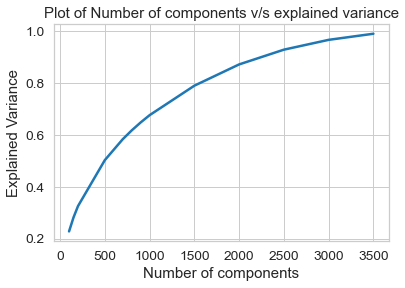

In [22]:
# To get the optimal # of components to be used in truncated SVD 

n_comp = [100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(train_data_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

### Creating adjacent matrix for Network Analysis using Gephi 

In [23]:
# Calculate similarity scores between documents in TFIDF

rows =train_data_tfidf.shape[0]

import numpy as np
similiary_matrix = np.empty((rows,rows))

for i in range(rows):
    similiary_scores = train_data_tfidf.dot(train_data_tfidf[i].toarray().T)
    similiary_matrix[i,:] = similiary_scores.T    

similiary_matrix[similiary_matrix < 0.5] = 0    

similiary_matrix_df = pd.DataFrame(data=similiary_matrix)
similiary_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Exporting to CSV for gephi to consume as input 

similiary_matrix_df.to_csv('Gephi_ip.csv')
import csv

with open('Gephi_ip.csv', 'r') as fin, \
     open('Gephi_ip.txt', 'w') as fout:
    reader = csv.DictReader(fin)
    writer = csv.DictWriter(fout, reader.fieldnames, delimiter=';')
    writer.writeheader()
    writer.writerows(reader)

### Pickling the Data and Vectorizers

In [86]:
# Pickling

import pickle

# Dump the trained vectorizer with Pickle
count_vectorizer_pkl_filename = 'count_vectorizer.pkl'
train_data_tfidf_filename = 'train_data_tfidf.pkl'  
train_data_lda_filename = 'train_data_lda.pkl'
topic_encoded_df_filename = 'topic_encoded_df.pkl'
result_svd_filename = 'result_svd.pkl'
result_features_filename = 'result_features.pkl'

# Open the file to save as pkl file
count_vectorizer_pkl = open(count_vectorizer_pkl_filename, 'wb')
pickle.dump(count_vectorizer, count_vectorizer_pkl)

train_data_tfidf_pkl = open(train_data_tfidf_filename, 'wb')
pickle.dump(train_data_tfidf,train_data_tfidf_pkl)

train_data_lda_pkl = open(train_data_lda_filename, 'wb')
pickle.dump(lda, train_data_lda_pkl)

topic_encoded_df_pkl = open(topic_encoded_df_filename, 'wb')
pickle.dump(topic_encoded_df, topic_encoded_df_pkl)

result_svd_pkl = open(result_svd_filename, 'wb')
pickle.dump(result_svd, result_svd_pkl)

result_features_pkl = open(result_features_filename, 'wb')
pickle.dump(result_features, result_features_pkl)

# Close the pickle instances
count_vectorizer_pkl.close()
train_data_tfidf_pkl.close()
train_data_lda_pkl.close()
topic_encoded_df_pkl.close()
result_svd_pkl.close()
result_features_pkl.close() 

# Pickle the train and test dataframes 
train_data.to_pickle("train_data.pkl")
#test_data.to_pickle("test_data.pkl")

## TESTING

###  Vectorizing the User Question  

In [30]:
# Applying TFIDF on User Question 

question = ' Does light therapy causes delirium  ?'
user_tfidf = count_vectorizer.transform([question])
print(type(user_tfidf))


<class 'scipy.sparse.csr.csr_matrix'>


### Recommenation Option 1 : Testing Using Cosine Similarity Option 


In [31]:
# Method 1 : Applying Similarity Scores 
import itertools

from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(train_data_tfidf,user_tfidf)
sorted_indicies = np.argsort(similarity_scores, axis = 0)[::-1]
sorted_sim_scores = similarity_scores[sorted_indicies][:5].tolist()

sorted_sim_scores = [item for items in sorted_sim_scores for item in items] 
#sorted_sim_scores = [item for items in sorted_sim_scores for item in items] 
#sorted_sim_scores = np.concatenate(sorted_sim_scores).ravel()
print(sorted_sim_scores)

sorted_indicies = sorted_indicies[:5].tolist()
sorted_indicies = [item for items in sorted_indicies for item in items]
#print(sorted_indicies)

top_n_recs = train_data.iloc[sorted_indicies]
print(top_n_recs[['id', 'custom_response_text']])

[[0.5836060496626151], [0.464717968054734], [0.4218688584222199], [0.3490472873336076], [0.31683901282916493]]
        id                               custom_response_text
532   3286  Data does not report that light therapy causes...
715   2787  There is little evidence regarding delirium ph...
3812  3301  The incidence of delirium arising during a hos...
383   2079  There are conflicting data regarding the effec...
2956  3344  While the overall strength of evidence is low,...


### Recommenation Option 2 : Testing Using KNN Distance Option

In [32]:
#  Method 2 : Finding the K Nearest neighbors 

from sklearn.neighbors import NearestNeighbors
n_neighbors = 5
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(train_data_tfidf)
NNs = KNN.kneighbors(user_tfidf, return_distance=True)

C:\Users\samra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [33]:
top = NNs[1][0][0:]
index_score = NNs[0][0][0:]

top = top.tolist()
index_score = index_score.tolist()

print(index_score)
#print(top)

[0.9125721345048675, 1.034680657928103, 1.0752963699164804, 1.1410107034260393, 1.1688977604314543]


In [34]:
top_nrec = train_data.iloc[top][['id', 'custom_response_text']]

print(top_nrec)

        id                               custom_response_text
532   3286  Data does not report that light therapy causes...
715   2787  There is little evidence regarding delirium ph...
3812  3301  The incidence of delirium arising during a hos...
383   2079  There are conflicting data regarding the effec...
2956  3344  While the overall strength of evidence is low,...


###  Recommenation Option 3 : Using LDA 

In [35]:
# Topic to which the user question is closely aligned to
user_tfidf
train_data_lda_tfidf = pd.read_pickle('train_data_lda.pkl')
result = train_data_lda_tfidf.transform(user_tfidf)
result

array([[0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.22091217, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.2976203 ,
        0.00389514, 0.00389514, 0.00389514, 0.00389514, 0.00389514,
        0.00389514, 0.00389514, 0.00389514, 0.23996888, 0.00389514]])

In [65]:
print(user_tfidf)

  (0, 28541)	0.27166359180065175
  (0, 16504)	0.7454404382128825
  (0, 8680)	0.6087014423894151


In [66]:
columns = []

for i in range(number_topics): 
    columns.append("topic_" + str(i))
    
pd.options.display.float_format = '{:,.16f}'.format
result_df = pd.DataFrame(result, columns=columns)
  

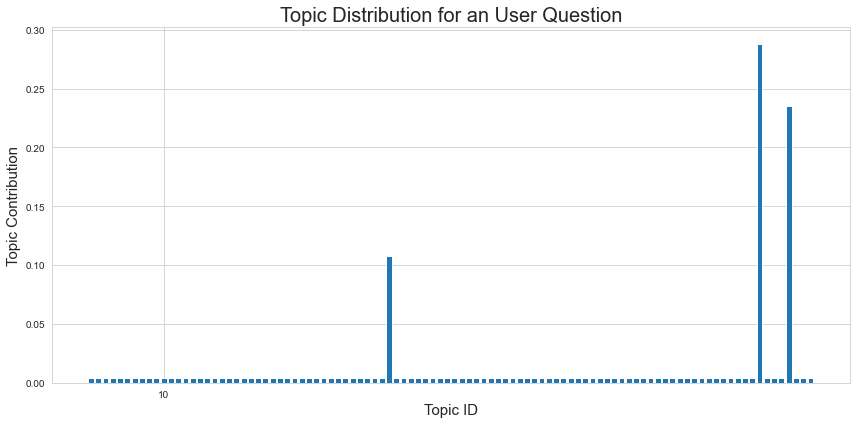

In [67]:

import matplotlib.pyplot as plt

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(result[0])), result[0])
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an User Question", fontsize=20)
ax.set_xticks(np.linspace(10,15,1))
fig.tight_layout()
plt.show()


In [68]:
# Get the top 2 topics associated with the user question 

top_topics = []

for i in result[0].argsort()[-2:][::-1]:
    top_topics.append("topic_" + str(i))

print(top_topics)

['topic_92', 'topic_96']


In [69]:
# Get documents whose topics are matching the users questions 

doc_filter_df = topic_encoded_df.loc[topic_encoded_df['probable_Topic'].isin(top_topics)]
#doc_filter_df[["id", "custom_response_text", "probable_Topic"]]
print(len(doc_filter_df))

160


In [70]:
#Get the tfidf vector for the subset of trained data set
train_data_filter_tfidf = train_data_tfidf[[index for index in doc_filter_df.index.values.tolist()]]


### 3A. Applying Cosine similarity on top of LDA 

In [56]:
# Method 3A : Applying Similarity Scores on the subset of Corpus based on LDA topic Modelling 
import itertools

from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(train_data_filter_tfidf,user_tfidf)
sorted_indicies = np.argsort(similarity_scores, axis = 0)[::-1]
sorted_sim_scores = similarity_scores[sorted_indicies][:5].tolist()

sorted_sim_scores = [item for items in sorted_sim_scores for item in items] 
#sorted_sim_scores = [item for items in sorted_sim_scores for item in items] 
print(sorted_sim_scores)

sorted_indicies = sorted_indicies[:5].tolist()
sorted_indicies = [item for items in sorted_indicies for item in items]
print(sorted_indicies)

top_n_recs = doc_filter_df.iloc[sorted_indicies]
print(top_n_recs[['id', 'custom_response_text']])





[[0.5836060496626151], [0.464717968054734], [0.4218688584222199], [0.3490472873336076], [0.31683901282916493]]
[365, 496, 2605, 261, 2033]
        id                               custom_response_text
532   3286  Data does not report that light therapy causes...
715   2787  There is little evidence regarding delirium ph...
3812  3301  The incidence of delirium arising during a hos...
383   2079  There are conflicting data regarding the effec...
2956  3344  While the overall strength of evidence is low,...


### 3B. Applying Jensen-Shanon on top of LDA 

In [57]:
# Method 3B :Jensen-Shanon Similarity method 
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

def jensen_shannon(query, matrix):
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

def get_most_similar_documents(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = np.array(jensen_shannon(query,matrix)) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [58]:
# Invoking the Jensen-Shanon function to get the recommendations 
result[0].shape
lda_result.shape

lda_result_filtered = lda.transform(train_data_filter_tfidf)

from scipy.stats import entropy
from scipy.spatial import distance
most_sim_ids = get_most_similar_documents(result[0],lda_result_filtered)

most_sim_ids
top_n_recs = train_data.iloc[most_sim_ids]
print(top_n_recs[['id', 'custom_response_text']])

        id                               custom_response_text
1928  6286  A medical information representative of Sandoz...
244   5784  Vancomycin capsules should not be administered...
523   2181  Misoprostol is currently available as an oral ...
615   4727  Evidence for use of tocilizumab mostly exists ...
2192  5822  While nitroimidazoles (i.e., metronidazole, ti...


###  Recommenation Option 4 : Using SVD

In [78]:
result_features.shape

(4167, 3000)

In [79]:
# Method 4 : Applying Similarity Scores on TrunSVD 
import itertools

from sklearn.metrics.pairwise import cosine_similarity

# Trasform the user_tfidf using trained Truncated_SVD
print ("User_features_orig.shape = {0}".format(user_tfidf.shape))

user_tsvd_tfidf = result_svd.transform(user_tfidf)

print ("User_features_tsvd.shape = {0}".format(user_tsvd_tfidf.shape))


similarity_scores = cosine_similarity(result_features , user_tsvd_tfidf)
sorted_indicies = np.argsort(similarity_scores, axis = 0)[::-1]
sorted_sim_scores = similarity_scores[sorted_indicies][:5].tolist()

sorted_sim_scores = [item for items in sorted_sim_scores for item in items] 
print(sorted_sim_scores)

sorted_indicies = sorted_indicies[:5].tolist()
sorted_indicies = [item for items in sorted_indicies for item in items]
print(sorted_indicies)

top_n_recs = train_data.iloc[sorted_indicies]
print(top_n_recs[['id', 'custom_response_text']])

User_features_orig.shape = (1, 41519)
User_features_tsvd.shape = (1, 3000)
[[0.5337502843576839], [0.4986008646766536], [0.495350112459924], [0.492464899071403], [0.491763122106918]]
[2848, 3022, 59, 91, 2494]
        id                               custom_response_text
2848  5032  A recent, pre-published, pre-guideline consens...
3022  2727  The use of heparin in patients with a pork all...
59    5800  There does not appear to be any literature on ...
91    4965  There is little to no published data on approp...
2494  5334  In depth information regarding treatments rela...
